
# Importing Libraries



In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
import time, numpy as np
import matplotlib.pyplot as plt

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

# Data

In [ ]:
path = untar_data(URLs.ML_100k)

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Converting 1-based indexing to 0-based indexing

In [ ]:
ratings['user'] = ratings['user'] - 1
ratings['movie'] = ratings['movie'] - 1

In [ ]:
new_ratings = csr_matrix(
    (ratings.rating.values, (ratings.user.values, ratings.movie.values)),
    shape=(len(ratings.user.unique()), len(ratings.movie.unique()))
).toarray()

# Matrix Factorization

In [ ]:
class MatrixFactorization():

    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.alpha = alpha
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self, ):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # initialize user & item vectors
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)


    def predict(self, u, i):
        return self.global_bias+self.user_biases[u]+self.item_biases[i]+self.user_vecs[u]@self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate*(error - self.alpha*self.user_biases[u])
        self.item_biases[i] += self.l_rate*(error - self.alpha*self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate*(error*self.item_vecs[i, :] - self.alpha*self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate*(error*self.user_vecs[u, :] - self.alpha*self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i]-pred_rat)**2
        mse = tot_square_error/self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time()-self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time()-self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self, ):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if self.stop == False:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i]-pred_rat
                    self.update_biases_and_vectors(error, u, i)

                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)

        self.plot_the_score()


    # Creates a line plot of MSE versus the number of epochs.
    def plot_the_score(self, ):
        plt.figure(figsize=(18,6))
        plt.plot(range(1, 1+len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num+5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst),15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 1.267 ===> Total training time: 0.465 seconds.
---> Epoch 1
ave mse 0.92 ===> Total training time: 3.397 seconds.
---> Epoch 2
ave mse 0.881 ===> Total training time: 6.861 seconds.
---> Epoch 3
ave mse 0.865 ===> Total training time: 9.984 seconds.
---> Epoch 4
ave mse 0.855 ===> Total training time: 12.216 seconds.
---> Epoch 5
ave mse 0.849 ===> Total training time: 14.449 seconds.
---> Epoch 6
ave mse 0.844 ===> Total training time: 16.655 seconds.
---> Epoch 7
ave mse 0.839 ===> Total training time: 18.895 seconds.
---> Epoch 8
ave mse 0.831 ===> Total training time: 22.535 seconds.
---> Epoch 9
ave mse 0.82 ===> Total training time: 24.789 seconds.
---> Epoch 10
ave mse 0.803 ===> Total training time: 27.015 seconds.
---> Epoch 11
ave mse 0.78 ===> Total training time: 29.244 seconds.
---> Epoch 12
ave mse 0.754 ===> Total training time: 31.499 seconds.
---> Epoch 13
ave mse 0.725 ===> Total training time: 35.075 seconds.
---> Epoch 14
ave mse 0.693 ===> Tota

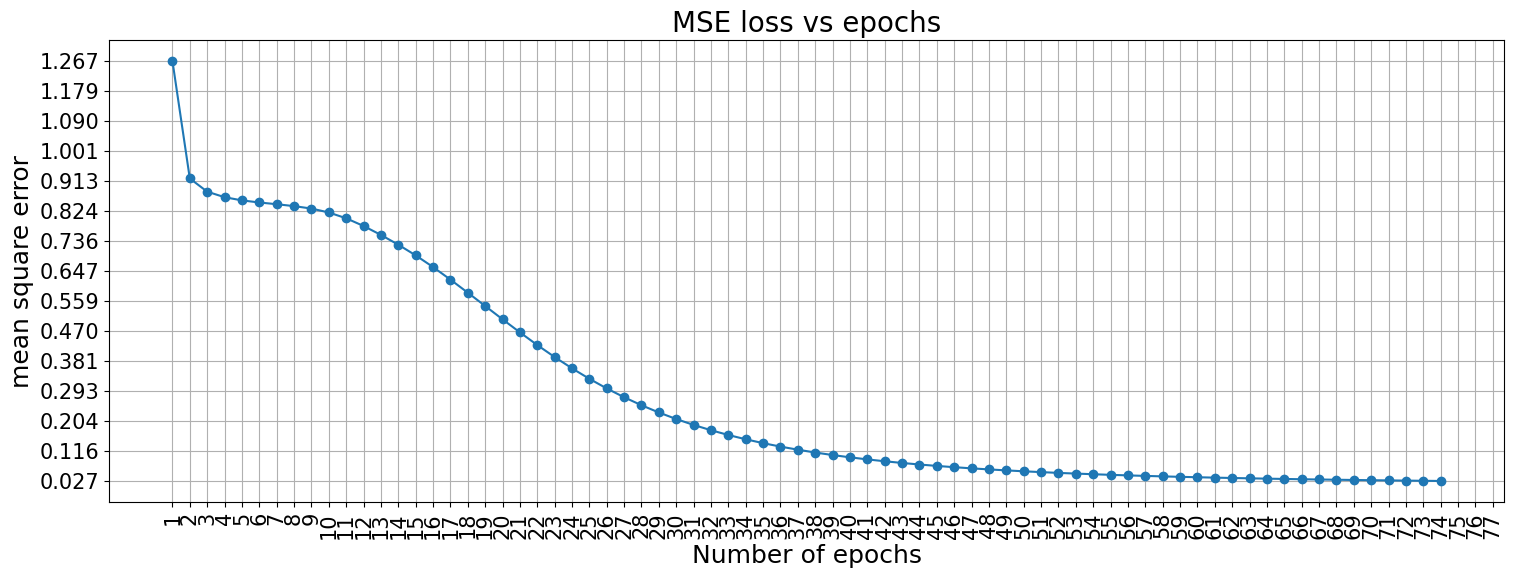

In [ ]:
obj = MatrixFactorization(new_ratings)
obj.fit()

# Recommend Function

Importing Library

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

Loading the movie titles from the 'u.item' file

In [ ]:
movies=pd.read_csv(path/'u.item',delimiter='|',encoding='latin-1',header=None,names=['movie_id','title'],usecols=[0,1])
movies['movie_id']=movies['movie_id']-1

Recommend function

In [ ]:
def recommend(movie_title, user_id, top_n):
    try:
        movie_id=movies[movies['title']==movie_title]['movie_id'].values[0]
    except IndexError:
        print(f"Movie'{movie_title}' not found in the dataset.")
        return []

    user_predicted_ratings=[obj.predict(user_id,i) for i in range(obj.n_items)]

    movie_vectors=obj.item_vecs
    similarity_scores=cosine_similarity([movie_vectors[movie_id]],movie_vectors)[0]

    recommendations=pd.DataFrame({
        'movie_id':range(obj.n_items),
        'predicted_rating':user_predicted_ratings,
        'similarity_score':similarity_scores
    })

    rated_movies=np.where(new_ratings[user_id]>0)[0]
    recommendations=recommendations[~recommendations['movie_id'].isin(rated_movies)]
    recommendations=recommendations.sort_values(by=['similarity_score','predicted_rating'],ascending=False)
    top_recommendations=recommendations.head(top_n)

    recommended_titles=movies[movies['movie_id'].isin(top_recommendations['movie_id'])]['title'].tolist()

    return recommended_titles

Example

In [ ]:
user_id=10
movie_title="Star Wars (1977)"
top_n=5

In [ ]:
recommended_movies=recommend(movie_title,user_id,top_n)
print(f"Top {top_n} recommendations for user {user_id} based on '{movie_title}':")
print(recommended_movies)

Top 5 recommendations for user 10 based on 'Star Wars (1977)':
['Star Wars (1977)', 'Empire Strikes Back, The (1980)', 'Raiders of the Lost Ark (1981)', 'Return of the Jedi (1983)', 'Butterfly Kiss (1995)']
